# Custom Hamiltonians

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/block-hczhai/block2-preview/blob/master/docs/source/tutorial/custom-hamiltonians.ipynb)

In [1]:
!pip install block2==0.5.4rc2 -qq --progress-bar off --extra-index-url=https://block-hczhai.github.io/block2-preview/pypi/


In this tutorial, we provide example python scripts for performing DMRG using custom Hamiltonians, where the operators and states at local Hilbert space at every site can be redefined. It is also possible to use different local Hilbert space for different sites. New letters can be introduced for representing new operators (the operator name can only be a single lower or upper case character).

Note the following examples are only supposed to work in the Abelian symmetry modes (``SZ``, ``SZ|CPX``, ``SGF``, ``SGFCPX``, ``SAny``, or ``SAny|CPX``) for Abelian symmetries, and non-Abelian symmetry modes (``SAnySU2`` or ``SAnySU2|CPX``) for non-Abelian symmetries, respectively.

## The Hubbard Model

In the following example, we implement a custom Hamiltonian for the Hubbard model. In the standard implementation, the on-site term was represented as ``cdCD``. Here we instead introduce a single letter ``N`` for the ``cdCD`` term. For each letter in ``cdCDN`` (representing elementary operators), we define its matrix representation in the local basis in ``site_ops``. The quantum number and number of states in each quantum number at each site (which defines the local Hilbert space) are set in ``site_basis``.



In [2]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np

L = 8
U = 2
N_ELEC = 8

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=L, n_elec=N_ELEC, spin=0)

# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []
Q = driver.bw.SX # quantum number wrapper (n_elec, 2 * spin, point group irrep)

for k in range(L):
    basis = [(Q(0, 0, 0), 1), (Q(1, 1, 0), 1), (Q(1, -1, 0), 1), (Q(2, 0, 0), 1)] # [0ab2]
    ops = {
        "": np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),   # identity
        "c": np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0]]),  # alpha+
        "d": np.array([[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]]),  # alpha
        "C": np.array([[0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, -1, 0, 0]]), # beta+
        "D": np.array([[0, 0, 1, 0], [0, 0, 0, -1], [0, 0, 0, 0], [0, 0, 0, 0]]), # beta
        "N": np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1]]),  # cdCD
    }
    site_basis.append(basis)
    site_ops.append(ops)

# [Part B] Set Hamiltonian terms
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

b.add_term("cd", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), -1)
b.add_term("CD", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), -1)
b.add_term("N", np.array([i for i in range(L)]), U)

# [Part C] Perform DMRG
mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops="cdCD"), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[250] * 4 + [500] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=1)
print("DMRG energy = %20.15f" % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.192 | E =      -6.2256341447 | DW = 2.65121e-16

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.266 | E =      -6.2256341447 | DE = -6.22e-15 | DW = 4.93004e-16

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.328 | E =      -6.2256341447 | DE = -3.55e-15 | DW = 9.61749e-17

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.392 | E =      -6.2256341447 | DE = -6.22e-15 | DW = 1.20255e-16

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      0.461 | E =      -6.2256341447 | DE = 8.88e-16 | DW = 3.25036e-20

Sweep =    5 | Direction = backward |

## The Hubbard-Holstein Model

The above script can be easily extended to treat phonons.

In [3]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np

N_SITES_ELEC, N_SITES_PH, N_ELEC = 4, 4, 4
N_PH, U, OMEGA, G = 11, 2, 0.25, 0.5
L = N_SITES_ELEC + N_SITES_PH

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=L, n_elec=N_ELEC, spin=0)

# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []
Q = driver.bw.SX # quantum number wrapper (n_elec, 2 * spin, point group irrep)

for k in range(L):
    if k < N_SITES_ELEC:
        # electron part
        basis = [(Q(0, 0, 0), 1), (Q(1, 1, 0), 1), (Q(1, -1, 0), 1), (Q(2, 0, 0), 1)] # [0ab2]
        ops = {
            "": np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),   # identity
            "c": np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0]]),  # alpha+
            "d": np.array([[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]]),  # alpha
            "C": np.array([[0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, -1, 0, 0]]), # beta+
            "D": np.array([[0, 0, 1, 0], [0, 0, 0, -1], [0, 0, 0, 0], [0, 0, 0, 0]]), # beta
        }
    else:
        # phonon part
        basis = [(Q(0, 0, 0), N_PH)]
        ops = {
            "": np.identity(N_PH), # identity
            "E": np.diag(np.sqrt(np.arange(1, N_PH)), k=-1), # ph+
            "F": np.diag(np.sqrt(np.arange(1, N_PH)), k=1),  # ph
        }
    site_basis.append(basis)
    site_ops.append(ops)

# [Part B] Set Hamiltonian terms in Hubbard-Holstein model
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# electron part
b.add_term("cd", np.array([[i, i + 1, i + 1, i] for i in range(N_SITES_ELEC - 1)]).ravel(), -1)
b.add_term("CD", np.array([[i, i + 1, i + 1, i] for i in range(N_SITES_ELEC - 1)]).ravel(), -1)
b.add_term("cdCD", np.array([[i, i, i, i] for i in range(N_SITES_ELEC)]).ravel(), U)

# phonon part
b.add_term("EF", np.array([[i + N_SITES_ELEC, ] * 2 for i in range(N_SITES_PH)]).ravel(), OMEGA)

# interaction part
b.add_term("cdE", np.array([[i, i, i + N_SITES_ELEC] for i in range(N_SITES_ELEC)]).ravel(), G)
b.add_term("cdF", np.array([[i, i, i + N_SITES_ELEC] for i in range(N_SITES_ELEC)]).ravel(), G)
b.add_term("CDE", np.array([[i, i, i + N_SITES_ELEC] for i in range(N_SITES_ELEC)]).ravel(), G)
b.add_term("CDF", np.array([[i, i, i + N_SITES_ELEC] for i in range(N_SITES_ELEC)]).ravel(), G)

# [Part C] Perform DMRG
mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops="cdCD"), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[250] * 4 + [500] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=1)
print("DMRG energy = %20.15f" % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =    115.653 | E =      -6.9568929222 | DW = 3.61640e-09

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =    147.576 | E =      -6.9568932112 | DE = -2.89e-07 | DW = 2.87947e-19

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =    157.876 | E =      -6.9568932112 | DE = 8.88e-16 | DW = 1.43993e-19

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =    166.732 | E =      -6.9568932112 | DE = -6.22e-15 | DW = 6.97202e-20

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =    178.749 | E =      -6.9568932112 | DE = -8.88e-16 | DW = 7.98168e-20

Sweep =    5 | Direction = backward |

## Custom Symmetry Groups

In the following we show how to set the custom symmetry groups. The symmetry mode ``SymmetryTypes.SAny`` (or ``SymmetryTypes.SAny | SymmetryTypes.CPX`` if complex number is required) should be used for this purpose. Currently we support the definition of symmetry group as an arbitrary direct product of up to six Abelian symmetry sub-groups. Possible sub-group names are "U1", "Z1", "Z2", "Z3", ..., "Z2055", "U1Fermi", "Z1Fermi", "Z2Fermi", "Z3Fermi", ..., "Z2055Fermi", "LZ", and "AbelianPG". The names with the suffix "Fermi" should be used for Fermion symmetries. The names without the suffix "Fermi" should be used for spin or Boson symmetries. The non-Abelian sub-group names "SU2" and "SU2Fermi" can be used with some restrictions, see the example in later sections. The ``DMRGDriver.set_symmetry_groups(sub_group_name_1: str, sub_group_name_2: str, ...)`` method can be used to set the symmetry sub-groups. The number of arguments in the quantum number wrapper ``Q`` should then match the number of sub-group names given in ``DMRGDriver.set_symmetry_groups``.

As a first example, we use the custom symmetry group syntax to recompute the Hubbard model. We first use $U(1) \times U(1)$ symmetry, which should be equivalent to the previous ``SZ`` mode example.

In [4]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np

L = 8
U = 2
N_ELEC = 8
TWO_SZ = 0

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

# quantum number wrapper (U1 / n_elec, U1 / 2*Sz)
driver.set_symmetry_groups("U1Fermi", "U1")
Q = driver.bw.SX

# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

for k in range(L):
    basis = [(Q(0, 0), 1), (Q(1, 1), 1), (Q(1, -1), 1), (Q(2, 0), 1)] # [0ab2]
    ops = {
        "": np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),   # identity
        "c": np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0]]),  # alpha+
        "d": np.array([[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]]),  # alpha
        "C": np.array([[0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, -1, 0, 0]]), # beta+
        "D": np.array([[0, 0, 1, 0], [0, 0, 0, -1], [0, 0, 0, 0], [0, 0, 0, 0]]), # beta
    }
    site_basis.append(basis)
    site_ops.append(ops)

# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0, 0), target=Q(N_ELEC, TWO_SZ), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

b.add_term("cd", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), -1)
b.add_term("CD", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), -1)
b.add_term("cdCD", np.array([i for i in range(L) for _ in range(4)]), U)

# [Part C] Perform DMRG
mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops="cdCD"), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[250] * 4 + [500] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=1)
print("DMRG energy = %20.15f" % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.177 | E =      -6.2256341447 | DW = 5.28456e-16

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.246 | E =      -6.2256341447 | DE = -7.11e-15 | DW = 6.68270e-16

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.325 | E =      -6.2256341447 | DE = -1.78e-15 | DW = 1.63441e-16

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.390 | E =      -6.2256341447 | DE = -1.78e-15 | DW = 2.16727e-16

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      0.470 | E =      -6.2256341447 | DE = -8.88e-16 | DW = 4.82164e-20

Sweep =    5 | Direction = backward 

As a second example, we recompute the Hubbard model using $Z_2 \times Z_2$ symmetry. This time we cannot easily target the $N_{\mathrm{elec}} = 8$ symmetry sector. Instead, we compute a few excited states and compute the $\langle N\rangle$ to identify the correct state.

In [5]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np

L = 8
U = 2
N_ELEC = 8
TWO_SZ = 0

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

# quantum number wrapper (Z2 / n_elec, Z2 / 2*Sz)
driver.set_symmetry_groups("Z2Fermi", "Z2")
Q = driver.bw.SX

# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

for k in range(L):
    basis = [(Q(0, 0), 2), (Q(1, 1), 2)] # [02ab]
    ops = {
        # note the order of row and column is different from the U1xU1 case
        "": np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),   # identity
        "c": np.array([[0, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 0, 0]]),  # alpha+
        "d": np.array([[0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 1, 0, 0]]),  # alpha
        "C": np.array([[0, 0, 0, 0], [0, 0, -1, 0], [0, 0, 0, 0], [1, 0, 0, 0]]), # beta+
        "D": np.array([[0, 0, 0, 1], [0, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 0]]), # beta
    }
    site_basis.append(basis)
    site_ops.append(ops)

# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0, 0), target=Q(N_ELEC % 2, TWO_SZ % 2), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

b.add_term("cd", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), -1)
b.add_term("CD", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), -1)
b.add_term("cdCD", np.array([i for i in range(L) for _ in range(4)]), U)

# [Part C] Perform state-averaged DMRG
mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops="cdCD"), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=250, nroots=10)
energies = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[250] * 4 + [500] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=200, iprint=1)

# [Part D] Check particle number expectations
b = driver.expr_builder()
b.add_term("cd", np.array([[i, i] for i in range(L)]).ravel(), 1)
b.add_term("CD", np.array([[i, i] for i in range(L)]).ravel(), 1)
partile_n_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops="cdCD"), algo_type=MPOAlgorithmTypes.FastBipartite)

kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]
for ir in range(mps.nroots):
    n_expt = driver.expectation(kets[ir], partile_n_mpo, kets[ir])
    print("Root = %d <E> = %20.15f <N> = %10.3f" % (ir, energies[ir], n_expt))


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =     37.644 | E[ 10] =      -6.9958183038     -6.5705972882     -6.5705972844     -6.5705972810     -6.2773135424     -6.2256341358     -6.1122535707     -6.1122534909     -6.1122534351     -6.0320900882 | DW = 4.44050e-09

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =     41.408 | E[ 10] =      -6.9958183059     -6.5705972895     -6.5705972895     -6.5705972895     -6.2773135514     -6.2256341447     -6.1122535739     -6.1122535739     -6.1122535739     -6.0320902499 | DE = -1.62e-07 | DW = 1.19074e-09

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =     44.964 | E[ 10] =      -6.9958183059     -6.5705972895     -6.5705972895     -6.5705972895     -6.2773135514     -6.2256341447     -6.1122535739     -6.1122535739 

## Bose-Hubbard Model

In this example we will find the ground state of 1D Bose-Hubbard model. Unlike the Holstein model, in this model the boson number is conserved as an Abelian U(1) symmetry. The definition of the Hamiltonian can be found in https://en.wikipedia.org/wiki/Bose%E2%80%93Hubbard_model, which is given by

$$
\hat{H} = -t \sum_{\langle ij\rangle} \Big( b^\dagger_i
  b_j + b^\dagger_j b_i \Big)
  + \frac{U}{2} \sum_i n_i (n_i - 1) - \mu \sum_i n_i
$$

In the following script, we consider a 1D chain including $L= 10$ sites with open boundary condition, $t = 1, U = 0.1$ and $\mu = 0$. The total number of boson in the many-body state is set to 10, and the maximal number of boson per site is 5.

In [6]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np

L = 10
T = 1
U = 0.1
MU = 0
NB_MAX = 5 # max n_boson per site
N_BOSON = 10

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

for k in range(L):
    basis = [(Q(i), 1) for i in range(NB_MAX + 1)] # [012..NB_MAX]
    ops = {
        "": np.identity(NB_MAX + 1),                           # identity
        "C": np.diag(np.sqrt(np.arange(1, NB_MAX + 1)), k=-1), # b+
        "D": np.diag(np.sqrt(np.arange(1, NB_MAX + 1)), k=1),  # b
        "N": np.diag(np.arange(0, NB_MAX + 1), k=0),           # particle number
    }
    site_basis.append(basis)
    site_ops.append(ops)

# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0), target=Q(N_BOSON), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

b.add_term("CD", np.array([j for i in range(L - 1) for j in [i, i + 1, i + 1, i]]), -T)
b.add_term("N", np.array([i for i in range(L)]), -(MU + U / 2))
b.add_term("NN", np.array([j for i in range(L) for j in [i, i]]), U / 2)

# [Part C] Perform DMRG
mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[250] * 4 + [500] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=1)
print("DMRG energy = %20.15f (per site = %10.6f)" % (energy, energy / L))


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      1.071 | E =     -18.5866885404 | DW = 4.34436e-12

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.548 | E =     -18.5873694219 | DE = -6.81e-04 | DW = 3.48016e-16

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.772 | E =     -18.5873694219 | DE = -2.49e-14 | DW = 3.31659e-17

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      2.997 | E =     -18.5873694219 | DE = 3.55e-15 | DW = 1.95060e-17

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      3.252 | E =     -18.5873694219 | DE = -3.55e-15 | DW = 1.68282e-19

Sweep =    5 | Direction = backward |

## SU(3) Heisenberg Model

In this example we will find the ground state of the 1D SU(3) Heisenberg model using the custom symemtry group syntax. We will only use Abelian symmetry groups (for quantum numbers $S_z$ and $Q_z$) for this problem. The model used here can be found in Eq. (2) in *Phys. Rev. B* **79**, 012408 (2009).

In [7]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np

L = 72

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

# quantum number wrapper (2Sz / X, 2Qz / Y)
driver.set_symmetry_groups("U1", "U1")
Q = driver.bw.SX

# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

# Gell Mann operators
lambda_ops = {
    "L1": np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]),              # lambda_1
    "L2": np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]]),           # lambda_2
    "L3": np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]),             # lambda_3
    "L4": np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]]),              # lambda_4
    "L5": np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]]),           # lambda_5
    "L6": np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]]),              # lambda_6
    "L7": np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]]),           # lambda_7
    "L8": np.array([[1, 0, 0], [0, 1, 0], [0, 0, -2]]) / 3 ** 0.5,  # lambda_8
}

for k in range(L):
    basis = [(Q(1, 1), 1), (Q(-1, 1), 1), (Q(0, -2), 1)]
    ops = {
        "": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),        # identity
        "T": (lambda_ops["L1"] + 1j * lambda_ops["L2"]).real,   # T+
        "t": (lambda_ops["L1"] - 1j * lambda_ops["L2"]).real,   # T-
        "V": (lambda_ops["L4"] + 1j * lambda_ops["L5"]).real,   # V+
        "v": (lambda_ops["L4"] - 1j * lambda_ops["L5"]).real,   # V-
        "U": (lambda_ops["L6"] + 1j * lambda_ops["L7"]).real,   # U+
        "u": (lambda_ops["L6"] - 1j * lambda_ops["L7"]).real,   # U-
        "L": lambda_ops["L3"],                                  # L3
        "l": lambda_ops["L8"],                                  # L8
    }
    site_basis.append(basis)
    site_ops.append(ops)

# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0, 0), target=Q(0, 0), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

b.add_term("Tt", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), 0.5 * 0.25)
b.add_term("Vv", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), 0.5 * 0.25)
b.add_term("Uu", np.array([[i, i + 1, i + 1, i] for i in range(L - 1)]).ravel(), 0.5 * 0.25)
b.add_term("LL", np.array([[i, i + 1] for i in range(L - 1)]).ravel(), 0.25)
b.add_term("ll", np.array([[i, i + 1] for i in range(L - 1)]).ravel(), 0.25)
b.iscale(1 / L) # compute energy per site instead of total energy

# [Part C] Perform DMRG
mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)

energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[250] * 4 + [500] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=1)
print("DMRG energy (per site) = %20.15f" % energy)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =     12.471 | E =      -0.5120463875 | DW = 1.17197e-05

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =     20.850 | E =      -0.5145214306 | DE = -2.48e-03 | DW = 3.98800e-08

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =     25.709 | E =      -0.5145506779 | DE = -2.92e-05 | DW = 3.53165e-07

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =     28.338 | E =      -0.5145508475 | DE = -1.70e-07 | DW = 4.89244e-07

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =     37.680 | E =      -0.5145512439 | DE = -3.96e-07 | DW = 4.94460e-09

Sweep =    5 | Direction = backward 

## SU(2) $t-J$ Model

As an example of non-Abelian custom symmetry groups, in the following we will find the ground state of the 2D SU(2) $t-J$ model using the custom symemtry group syntax. We will use the $\mathrm{U(1) \times SU(2)}$ symmetry group (for particle number $N$ and total spin $S$) for this problem.

The $t-J$ model Hamiltonian is given by

$$
\hat{H} = -t \sum_{\langle ij\rangle, \sigma} \Big( a^\dagger_{i\sigma}
  a_{j\sigma} + a^\dagger_{j\sigma} a_{i\sigma} \Big)
  + J \sum_{\langle ij\rangle} \Big( \mathbf{\hat{S}}_i \cdot \mathbf{\hat{S}}_j - \frac{1}{4} n_i n_j \Big)
$$

We consider $4\times 4$ square 2D lattice with open boundary condition, $t = 1, J = 0.4$, and hole doping $=1/8$. $\langle ij\rangle$ only conatins one of $i=1, j=2$ and $i=2, j=1$, for example. The reference energy per site can be found in *npj Quantum Materials* **5**, 28 (2020).

Written in SU(2) notation, the Hamiltonian is

$$
\hat{H} = -\sqrt{2} t \sum_{\langle ij\rangle} \Big(
  \big(a^\dagger_i\big)^{[1/2]} \otimes_{[0]} \big(a_j\big)^{[1/2]} +
  \big(a^\dagger_j\big)^{[1/2]} \otimes_{[0]} \big(a_i\big)^{[1/2]} \Big) \\
   + J \sum_{\langle ij\rangle} \Big[ -\frac{\sqrt{3}}{2}
   \Big( \big(a^\dagger_i\big)^{[1/2]} \otimes_{[1]} \big(a_i\big)^{[1/2]}
  \Big)\otimes_{[0]} \Big(
  \big(a^\dagger_j\big)^{[1/2]} \otimes_{[1]} \big(a_j\big)^{[1/2]}
  \Big) \\
  - \frac{(\sqrt{2})^2}{4}
  \Big( \big(a^\dagger_i\big)^{[1/2]} \otimes_{[0]} \big(a_i\big)^{[1/2]}
  \Big)\otimes_{[0]} \Big(
  \big(a^\dagger_j\big)^{[1/2]} \otimes_{[0]} \big(a_j\big)^{[1/2]}
  \Big)
   \Big]
$$

In [8]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np

LX, LY = 4, 4
L = LX * LY
J = 0.4
N_ELEC = 14 # 1/8 doping
TWO_S = 0

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAnySU2, n_threads=4)

driver.set_symmetry_groups("U1Fermi", "SU2", "SU2")
Q = driver.bw.SX

# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

for k in range(L):
    basis = [(Q(0, 0, 0), 1), (Q(1, 1, 1), 1)] # [01]
    ops = {
        "": np.array([[1, 0], [0, 1]]),        # identity
        "C": np.array([[0, 0], [1, 0]]),       # a+
        "D": np.array([[0, 2**0.5], [0, 0]]),  # a
    }
    site_basis.append(basis)
    site_ops.append(ops)

# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0, 0, 0), target=Q(N_ELEC, TWO_S, TWO_S), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

f = lambda i, j: i * LY + j if i % 2 == 0 else i * LY + LY - 1 - j

for i in range(0, LX):
    for j in range(0, LY):
        if i + 1 < LX:
            b.add_term("(C+D)0", [f(i, j), f(i + 1, j), f(i + 1, j), f(i, j)], -(2 ** 0.5))
            b.add_term("((C+D)2+(C+D)2)0", [f(i, j), f(i, j), f(i + 1, j), f(i + 1, j)], J * -(3 ** 0.5) / 2)
            b.add_term("((C+D)0+(C+D)0)0", [f(i, j), f(i, j), f(i + 1, j), f(i + 1, j)], J * -1 / 2)
        if j + 1 < LY:
            b.add_term("(C+D)0", [f(i, j), f(i, j + 1), f(i, j + 1), f(i, j)], -(2 ** 0.5))
            b.add_term("((C+D)2+(C+D)2)0", [f(i, j), f(i, j), f(i, j + 1), f(i, j + 1)], J * -(3 ** 0.5) / 2)
            b.add_term("((C+D)0+(C+D)0)0", [f(i, j), f(i, j), f(i, j + 1), f(i, j + 1)], J * -1 / 2)

# [Part C] Perform DMRG
mpo = driver.get_mpo(b.finalize(adjust_order=True), algo_type=MPOAlgorithmTypes.FastBipartite, iprint=1)
mps = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[250] * 4 + [500] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=1)
print("DMRG energy = %20.15f (per site = %10.6f)" % (energy, energy / L))


Build MPO | Nsites =    16 | Nterms =         96 | Algorithm = FastBIP | Cutoff = 1.00e-14
 Site =     0 /    16 .. Mmpo =     5 DW = 0.00e+00 NNZ =        5 SPT = 0.0000 Tmvc = 0.000 T = 0.006
 Site =     1 /    16 .. Mmpo =    10 DW = 0.00e+00 NNZ =       13 SPT = 0.7400 Tmvc = 0.000 T = 0.005
 Site =     2 /    16 .. Mmpo =    14 DW = 0.00e+00 NNZ =       18 SPT = 0.8714 Tmvc = 0.000 T = 0.008
 Site =     3 /    16 .. Mmpo =    18 DW = 0.00e+00 NNZ =       22 SPT = 0.9127 Tmvc = 0.000 T = 0.004
 Site =     4 /    16 .. Mmpo =    18 DW = 0.00e+00 NNZ =       22 SPT = 0.9321 Tmvc = 0.000 T = 0.008
 Site =     5 /    16 .. Mmpo =    18 DW = 0.00e+00 NNZ =       26 SPT = 0.9198 Tmvc = 0.000 T = 0.004
 Site =     6 /    16 .. Mmpo =    18 DW = 0.00e+00 NNZ =       26 SPT = 0.9198 Tmvc = 0.000 T = 0.004
 Site =     7 /    16 .. Mmpo =    18 DW = 0.00e+00 NNZ =       26 SPT = 0.9198 Tmvc = 0.000 T = 0.006
 Site =     8 /    16 .. Mmpo =    18 DW = 0.00e+00 NNZ =       22 SPT = 0.9321 Tmvc

## Spatial Reflection Symmetry

As a more advanced example, in the following we solve the Heisenberg model
$$
\hat{H} = \sum_{i=1}^{L-1} \Big( \frac{1}{2} S^+_{i} S^-_{i+1} + \frac{1}{2} S^-_{i} S^+_{i+1} + S^z_{i} S^z_{i+1} \Big)
$$
using $U(1) \times Z_2$ (projected spin $\hat{S}_z$ and spatial reflection $\hat{R}$ about the center of the chain) symmetry.

First, we need to transform the local states so that they have well defined quantum numbers in the $U(1) \times Z_2$ symmetry group. Consider a two-site system. The states can be represented as $|\alpha\alpha\rangle,|\alpha\beta\rangle,|\beta\alpha\rangle$, and $|\beta\beta\rangle$. Since $\hat{R}|\alpha\beta\rangle=|\beta\alpha\rangle$, states $|\alpha\beta\rangle$ and $|\beta\alpha\rangle$ do not have well-defined quantum number for $\hat{R}$. Therefore, we define the following four local states for the two-site system:

$$
|0\rangle = |\alpha\alpha\rangle,\quad
|1\rangle = \big(|\alpha\beta\rangle + |\beta\alpha\rangle \big) / \sqrt{2},\quad
|2\rangle = \big(|\alpha\beta\rangle - |\beta\alpha\rangle \big) / \sqrt{2},\quad
|3\rangle = |\beta\beta\rangle.
$$
which are four eigenstates of the $\hat{R}$ operator with eigenvalues $+1, +1, -1, +1$. In $Z_2$ notation, the quantum number will be 0 (even, $R = +1$) or 1 (odd, $R = -1$).

For a $L$-site system, the above local states will mix states in site 0 and $L - 1$, and in site 1 and $L - 2$, etc. Therefore, we reorder the sites according to (using $L = 8$ as an example):

$$
01234567 \quad\rightarrow\quad (07)(16)(25)(34)
$$

and merge the two sites in each parenthesis into one big site.

Second, we need to transform the local operators so that they have well defined quantum numbers in the $U(1) \times Z_2$ symmetry group. We first write each operator in the above $|0\rangle, |1\rangle, |2\rangle, |3\rangle$ basis. Since now each big site has four states, we have two $\hat{S}^+$ operators denoted as $\hat{S}^+_L$ and $\hat{S}^+_R$, acting on the site from the left-half-chain and the right-half-chain, respectively (for example, when $L=8$, in the first big site, $\hat{S}^+_L = \hat{S}^+_0$ and $\hat{S}^+_R = \hat{S}^+_7$). We have

$$
\hat{S}_L^+ = \frac{1}{\sqrt{2}}\begin{pmatrix} 0 & 1 & -1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\\end{pmatrix}
$$

As $\hat{S}_L^+$ do not commute or anticommute with $\hat{R} = \mathrm{diag}(1, 1, -1, 1)$, we split it into the odd and even parts:
$$
\hat{S}^+_{L,\mathrm{odd}} = \frac{1}{\sqrt{2}}\begin{pmatrix} 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\\end{pmatrix},\quad
\hat{S}^+_{L,\mathrm{even}} = \frac{1}{\sqrt{2}}\begin{pmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\\end{pmatrix}
$$

such that $[\hat{S}^+_{L,\mathrm{odd}}, \hat{R}]_+ = 0$ and $[\hat{S}^+_{L,\mathrm{even}}, \hat{R}]_- = 0$.

The other operators can be symmetry-adapted in a similar way.

Finally, for the Hamiltonian we require $[\hat{H}, \hat{R}]_- = 0$. So terms like $S^+_{i}S^-_{i+1}$ will be rewritten as

$$
S^+_{i,\mathrm{odd}}S^-_{i+1,\mathrm{odd}} + S^+_{i,\mathrm{even}}S^-_{i+1,\mathrm{even}}.
$$

The following script will compute the $R = +1$ (spatial reflection even) state and the $R = -1$ (spatial reflection odd) state (both with $S_z=0$) for $L = 16$ Heisenberg model. The two states correspond to the ground state and the first excited state of the model when computed using only $U(1)$ symmetry, respectively.

In [9]:
import numpy as np
from pyblock2.driver.core import DMRGDriver, SymmetryTypes

L = 16

bond_dims = [100] * 4 + [200] * 6
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 10

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

X = (L + 1) // 2

# U1: spin, Z2: spatial reflection
driver.set_symmetry_groups('U1', 'Z2')
Q = driver.bw.SX

site_basis, site_ops = [], []
for k in range(X):
    if L % 2 == 0 or k < L // 2:
        site_basis.append([(Q(-2, 0), 1), (Q(0, 0), 1), (Q(0, 1), 1), (Q(2, 0), 1)]) # [0+-2]
        ops = {
            "": np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), # identity
            "L": np.array([[0, 0, -1, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]]) / (2**0.5), # S+ left odd
            "l": np.array([[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]]) / (2**0.5), # S+ left even
            "R": np.array([[0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, -1], [0, 0, 0, 0]]) / (2**0.5), # S+ right odd
            "r": np.array([[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]]) / (2**0.5), # S+ right even
            "S": np.array([[0, 0, 0, 0], [0, 0, 0, 0], [-1, 0, 0, 0], [0, 0, 1, 0]]) / (2**0.5), # S- left odd
            "s": np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 1, 0, 0]]) / (2**0.5), # S- left even
            "T": np.array([[0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, 0, -1, 0]]) / (2**0.5), # S- right odd
            "t": np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 1, 0, 0]]) / (2**0.5), # S- right even
            "V": np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]) * 0.5, # Sz left odd
            "v": np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, -1]]) * 0.5, # Sz left even
            "W": np.array([[0, 0, 0, 0], [0, 0, -1, 0], [0, -1, 0, 0], [0, 0, 0, 0]]) * 0.5, # Sz right odd
            "w": np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, -1]]) * 0.5, # Sz right even
        }
    else:
        site_basis.append([(Q(-1, 0), 1), (Q(1, 0), 1)]) # [01/ab]
        ops = {
            "": np.array([[1, 0], [0, 1]]), # identity
            "l": np.array([[0, 1], [0, 0]]), # S+
            "s": np.array([[0, 0], [1, 0]]), # S-
            "v": np.array([[0.5, 0], [0, -0.5]]) # Sz
        }
    site_ops.append(ops)

driver.initialize_system(n_sites=X, vacuum=Q(0, 0), target=Q(L % 2, 0), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)

b = driver.expr_builder()
for i in range(L - 1):
    term = (i == L // 2 or i + 1 == L // 2) and L % 2 == 1
    for p, m in [(p, m) for p, m in [["LR", "ST"], ["lr", "st"]][term:]]:
        b.add_term(p[i >= X] + m[i + 1 >= X], [[i, L - 1 - i][i >= X], [i + 1, L - 2 - i][i + 1 >= X]], 0.5)
    for m, p in [(m, p) for m, p in [["ST", "LR"], ["st", "lr"]][term:]]:
        b.add_term(m[i >= X] + p[i + 1 >= X], [[i, L - 1 - i][i >= X], [i + 1, L - 2 - i][i + 1 >= X]], 0.5)
    for z, w in [(z, w) for z, w in [["VW", "VW"], ["vw", "vw"]][term:]]:
        b.add_term(z[i >= X] + w[i + 1 >= X], [[i, L - 1 - i][i >= X], [i + 1, L - 2 - i][i + 1 >= X]], 1.0)

mpo = driver.get_mpo(b.finalize(fermionic_ops=""), iprint=0)

energies = [0.0] * 2
for r in [0, 1]:
    ket = driver.get_random_mps(tag="KET", bond_dim=100, target=Q(L % 2, r), nroots=1)
    energies[r] = driver.dmrg(mpo, ket, n_sweeps=len(bond_dims), bond_dims=bond_dims, noises=noises, thrds=thrds, iprint=1)

print('R = even : DMRG energy = %20.15f' % energies[0])
print('R =  odd : DMRG energy = %20.15f' % energies[1])


Sweep =    0 | Direction =  forward | Bond dimension =  100 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.218 | E =      -6.9117371456 | DW = 4.53183e-09

Sweep =    1 | Direction = backward | Bond dimension =  100 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.276 | E =      -6.9117371456 | DE = -1.86e-11 | DW = 4.11573e-09

Sweep =    2 | Direction =  forward | Bond dimension =  100 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.335 | E =      -6.9117371456 | DE = -2.48e-13 | DW = 4.52743e-09

Sweep =    3 | Direction = backward | Bond dimension =  100 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.395 | E =      -6.9117371456 | DE = 3.64e-14 | DW = 4.11606e-09

Sweep =    4 | Direction =  forward | Bond dimension =  200 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      0.478 | E =      -6.9117371456 | DE = -4.26e-14 | DW = 8.44753e-14

Sweep =    5 | Direction = backward |

## Correlation Functions

In this section we explain how to compute correlation functions (such as reduced density matrices and spin-spin correlation functions). We use the Hubbard model in the custom SU(2) symmetry mode as an example.

Correlation Functions can be computed using ``DMRGDriver.get_npdm`` with a custom ``npdm_expr``. For spin-spin correlation in the SU(2) mode, additional factor ``(-(3 ** 0.5) / 4)`` is required due to the SU(2) convention used in the ``block2`` code. Standard reduced density matrices can also be obtained from ``DMRGDriver.get_1pdm``, etc without setting ``npdm_expr``.

The optional ``mask`` argument in ``DMRGDriver.get_npdm`` can be used to set a pattern with repeated integers indicating the operators that should take the same site indices. For example, when ``mask=[0, 1, 2, 1]``, only $\mathrm{DM}_{ijkj}$ will be computed and output as $\mathrm{DM}_{ijk}$.

The optional ``index_mask`` argument in ``DMRGDriver.get_npdm`` can be used to set the allowed site indices for each operator. For example, ``index_masks=[[0, 3], [1, 2]]`` will only compute $\mathrm{DM}_{0, 1}, \mathrm{DM}_{0, 2}, \mathrm{DM}_{3, 1}\mathrm{DM}_{3, 2}$ and output the result as a $2\times 2$ matrix. When both ``mask`` and ``index_mask`` appear, the list of site indices given in ``index_mask`` for the repeated number in the ``mask`` should be the same (a runtime error will raise if this is not satisfied). For Hubbard-Holstein model, ``index_mask`` can also be used to limit operators to have only site indices for electron or phonon sites.

For non-SU(2) (Abelian) symmtry modes, when there is a mixture of custom fermionic and non-fermionc operators, the ``fermionic_ops`` argument should be used to indicate which operators are fermionic.

In [10]:
import numpy as np
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes

L = 8
U = 2
N_ELEC = 8

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAnySU2, n_threads=4)

driver.set_symmetry_groups("U1Fermi", "SU2", "SU2")
Q = driver.bw.SX

# [Part A] Set states and matrix representation of operators in local Hilbert space
ops = {
    "": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),            # identity
    "C": np.array([[0, 0, 0], [1, 0, 0], [0, -(2**0.5), 0]]),   # +
    "D": np.array([[0, 2**0.5, 0], [0, 0, 1], [0, 0, 0]]),      # -
}
site_basis = [[(Q(0, 0, 0), 1), (Q(1, 1, 1), 1), (Q(2, 0, 0), 1)] for _ in range(L)]
site_ops = [ops  for _ in range(L)]

# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0, 0, 0), target=Q(N_ELEC, 0, 0), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()
b.add_term("(C+D)0", [x for i in range(L - 1) for x in [i, i + 1, i + 1, i]], -(2 ** 0.5))
b.add_term("((C+(C+D)0)1+D)0", [x for i in range(L) for x in [i, i, i, i]], U)

# [Part C] Perform DMRG
mpo = driver.get_mpo(b.finalize(adjust_order=True), algo_type=MPOAlgorithmTypes.FastBipartite)
ket = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=10, bond_dims=[250] * 4 + [500] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=1)
print("DMRG energy = %20.15f" % energy)

# [Part D] Correlation functions

# reduced density matrix <CiDj>
rdm1 = driver.get_npdm(ket, pdm_type=1, npdm_expr='(C+D)0', max_bond_dim=500)
assert np.linalg.norm(rdm1 - driver.get_1pdm(ket, max_bond_dim=500)) < 1E-10

# spin correlation <Si.Sj>
spin_corr = driver.get_npdm(ket, pdm_type=2, npdm_expr='((C+D)2+(C+D)2)0',
    mask=(0, 0, 1, 1), max_bond_dim=500) * (-(3 ** 0.5) / 4)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.100 | E =      -6.2256341447 | DW = 1.96156e-20

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.142 | E =      -6.2256341447 | DE = 6.22e-15 | DW = 2.06683e-20

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.197 | E =      -6.2256341447 | DE = -8.88e-16 | DW = 1.43428e-20

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.245 | E =      -6.2256341447 | DE = -1.78e-15 | DW = 1.91736e-20

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      0.289 | E =      -6.2256341447 | DE = 8.88e-16 | DW = 1.76679e-20

Sweep =    5 | Direction = backward | 

One may use ``index_masks`` to compute only the correlation between site 0 and all sites and plot the result.

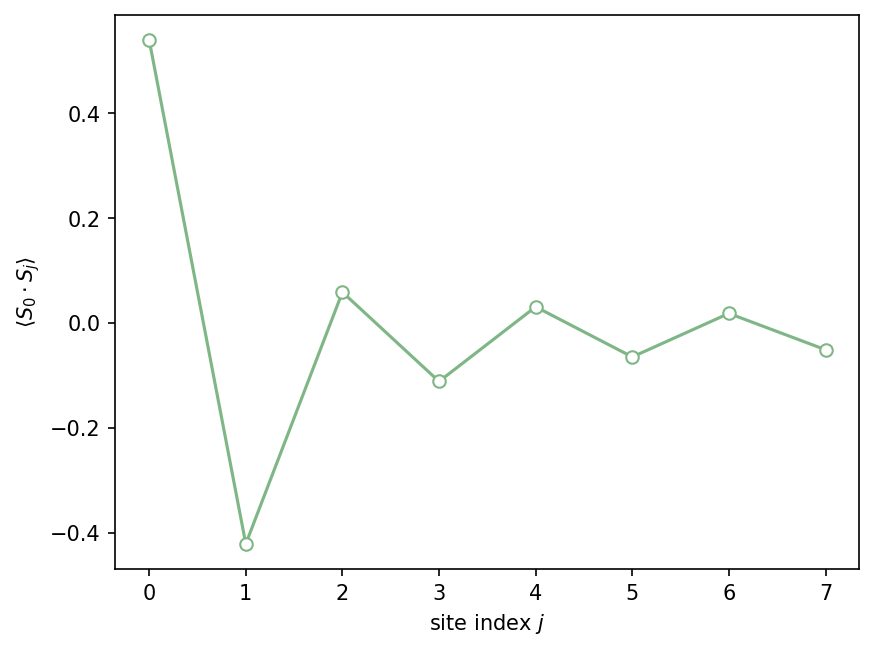

In [11]:
# spin correlation for site 0 <S0.Sj>
spin_corr_0 = driver.get_npdm(ket, pdm_type=2, npdm_expr='((C+D)2+(C+D)2)0',
    mask=(0, 0, 1, 1), index_masks=[[0], [0]] + [range(L)] * 2, max_bond_dim=500) * (-(3 ** 0.5) / 4)
assert np.linalg.norm(spin_corr_0 - spin_corr[0:1]) < 1E-10

import matplotlib.pyplot as plt
plt.plot(np.mgrid[:len(spin_corr_0[0])], spin_corr_0[0], linestyle='-', marker='o',
    mfc='white', mec="#7FB685", color="#7FB685")
plt.xlabel("site index $j$")
plt.ylabel("$\\langle S_0\\cdot S_j\\rangle $")
plt.gcf().set_dpi(150)
plt.show()